# Libraries and Settings

In [1]:
##########==========##########==========##########==========##########==========

## import full packages
import numpy as np
import pandas as pd
import cartopy as ct
import datetime as dt
import fastkml as kml
import matplotlib.pyplot as plt

## import specific functions
from matplotlib.colors import hsv_to_rgb, to_hex
from matplotlib import font_manager
from matplotlib.gridspec import GridSpec
from shapely.geometry import MultiLineString, LineString
from geopy.distance import distance as earth_distance

def hsv(h, s, v):
    y = np.column_stack((np.array(h), np.array(s), np.array(v)))
    y = to_hex(hsv_to_rgb(y)[0])
    return y

## general purpose visualization settings
set_font = {'L':48, 'M':32, 'S': 16}

set_color = {
    'Foreground': hsv(0, 0, 0),
    'Background': hsv(7/12, 0.05, 1.0),
    'Dividers'  : hsv(7/12, 1.00, 0.5),

    'Coast':  hsv(7/12, 0.50, 0.7),
    'Border': hsv(1/12, 0.05, 0.8),
    'Land':   hsv(1/12, 0.05, 1.0),

    'Photo':   hsv(1/12, 0.8, 0.3),
    'Visit':   hsv(1/12, 0.8, 0.6),
    'Unvisit': hsv(1/12, 0.2, 1.0)
}

set_misc = {
    'reset_scores': False,
    'prox_threshold': 100,
    'manual_test': False
    }

set_text_dim = {
    'explanation':(54, 590),
    'progress':(53, 200),
    'opportunity':(23, 65),
    'routes':(23, 65),
    'legend_plus':(None, None),
    'travels':(50, 295)
    }

set_bbox = dict(
    fc = set_color['Background'] + '80',
    ec = set_color['Coast'] + '40',
    boxstyle = 'Round')

## general purpose cartography data
map_projection = ct.crs.LambertConformal(
        central_longitude = (-124.73 - 66.95) / 2,
        central_latitude = (25.12 + 49.38) / 2,
        standard_parallels = (25.12, 49.38)
        )

map_extent = [-124.73 + 5, -66.95 - 5, 25.12 - 3.3, 49.38 + 3.3]

## function to express time stamps
def time_check(s = 'Alfa'):
    print('Time Check: Point ' + s)
    print(dt.datetime.now())
time_check('A')
    
## create test objects
test_failures = []
manual_check_list = {
    'Are there six panels?':'y',
    'Do all panels have titles?':'y',
    'Do all panels have supporting text?':'y',
    'Is the top right panel four times the size of the other panels?':'y',
    'Do all elements fit inside their respective panels?':'y',
    'Do none of the elements obscure other elements?':'y',
    'Are there 3 maps that show all 48 coterminous US states?':'y'
    }

Time Check: Point A
2022-03-26 10:27:08.473269


# Read in data

### read in docx files

In [2]:
## text formater helper function
def format_text(x, cl):
    ## prepare for text processing
    x = x.split(" ")
    even_lines = [x[0]]
    x = x[1:]
    current_line = 0
    ## segment text into lines <= set_max_width characters
    for i in x:
        if len(even_lines[current_line] + ' ' + i) > cl:
            current_line += 1
            even_lines.append(i)
        else:
            even_lines[current_line] = even_lines[current_line] + ' ' + i
    ## combine lines into a single string
    y = str()
    for i in even_lines:
        y = y + '\n' + i
    return y

def loop_format_text(x, char_len):
    y = ''
    for i in x:
        formatted_x = format_text(i, cl = char_len)
        y = y + formatted_x
    y = y.replace('\n', '', 1)
    return y

## read in text blurbs
def import_texts(address = 'A_Input/paragraph_text'):
    ## import text
    from os import listdir
    from docx import Document
    x = listdir(address)
    y = dict()
    extract_text = lambda x: x.text
    for i in x:
        if i.startswith('~'): continue
        if i.startswith('.'): continue
        j = Document(address + '/' + i).paragraphs
        j = map(extract_text, j)
        y[i.replace('.docx', '')] = list(j)
    ## format text to fit into plot spaces
    for i in y.keys():
        y[i] = loop_format_text(y[i], set_text_dim[i][0])
    
    return y

panel_paragraph = import_texts()

### test docx files

In [3]:
## test text blurbs
def test_texts():
    
    full_pass = True
    
    ## Does the explanation object instantiate the right class? (Mandatory pass)
    assert isinstance(panel_paragraph, dict)
    
    ## Is there an explanation for each panel?
    all_panels = set(['travels', 'explanation', 'routes', 'progress', 'opportunity', 'legend_plus'])
    if all_panels != set(panel_paragraph.keys()):
        print("WARNING (test_texts) - Some explanatory texts are missing")
        full_pass = False
        
    ## Is the longest line in each text block less than the maximum width?
    long_line_fit = dict()
    for i in panel_paragraph.keys():
        long_line_fit.update({i:max(map(len, panel_paragraph[i].split('\n')))})
        long_line_fit[i] = set_text_dim[i][0] - long_line_fit[i]
    if min(long_line_fit.values()) < 0:
        print('WARNING (test_texts) - Some explanatory texts exceed '
              + 'line length maximum')
        full_pass = False
        
    ## Is each text block less than the maximum character count?
    char_count_fit = [set_text_dim[i][1] - sum(map(len, panel_paragraph[i])) \
                      for i in panel_paragraph.keys()]
    if min(char_count_fit) < 0:
        print('WARNING (test_texts) - Some explanatory texts exceed '
              + 'character maximum')
        full_pass = False
              
    ## Does the import process mangle text?
    test_phrase = 'THIS IS PLACEHOLDER TEXT'
    actual_ending = panel_paragraph['explanation'][
        len(panel_paragraph['explanation']) - 1]
    if test_phrase != actual_ending[-len(test_phrase):]:
        print('WARNING (test_texts) - Final sentence of sample explanation '
              + 'doesn\'t match test phrase')
        full_pass = False
        
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_texts')
    
test_texts()

WARNING (test_texts) - Some explanatory texts are missing
WARNING (test_texts) - Some explanatory texts exceed character maximum
WARNING (test_texts) - Final sentence of sample explanation doesn't match test phrase


### read in xlsx files

In [4]:
## read in excel files (testing waived, since this is well-tested, pre-packaged code)
city_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Cities')
route_list = pd.read_excel('A_Input/city_list.xlsx', sheet_name = 'Routes',
    usecols = ['route', 'pre_travel', 'drive_mileage', 'trip_days',
               'best_temp_1', 'best_temp_2', 'states_etc'])

## reset scoring to show all opportunities, regardless of past travels
if set_misc['reset_scores']:
    city_list['Score'] = 2
    city_list['Visit'] = 0
    city_list['Photo'] = 0

### read in kml files

In [5]:
## read in kml files
def read_kmls(address):
    read_connection = open(address, 'rt', encoding = 'utf-8')
    read_iter = read_connection.read().encode('utf-8')
    kml_data = kml.KML()
    kml_data.from_string(read_iter)
    read_connection.close()
    return kml_data

def process_kmls(kml_obj):

    ## extract route names
    get_name_attr = lambda a: a.name
    def extract_names(x):
        if len(list(x.features())) > 1:
            y = list(x.features())
            y = map(get_name_attr, y)
            return list(y)
        else:
            return extract_names(list(x.features())[0])

    geo_names = extract_names(kml_obj)
        
    ## extract route line strings
    get_geometry_attr = lambda a: a.geometry
    def extract_linestrings(x):
        if isinstance(x, kml.Placemark):
            return x.geometry
        else:
            return map(extract_linestrings, x.features())
            
    line_strings = extract_linestrings(kml_obj)
    
    ## extract linestrings for superfluous nesting
    def unnest_map(x):
        x = list(x)
        if len(x) == 1:
            return unnest_map(x[0])
        else:
            return list(map(list, x))
    line_strings = unnest_map(line_strings)
    
    ## merge linestrings that are part of the same route
    line_strings = map(MultiLineString, line_strings)
    
    ## package names and routes
    y = dict()
    for i in range(len(geo_names)):
        y[geo_names[i]] = next(line_strings)
    return y

## execute
routes  = read_kmls('A_Input/Wishlist.kml')
routes = process_kmls(routes)

travels = read_kmls('A_Input/Travels.kml' )
travels = process_kmls(travels)

### test kml code

In [6]:
## declare helper function to extract the names of folders
def extract_folder_names(address):
    kml_conn = open(address)
    folder_names = []
    current_line_number, grab_next = 0, False
    
    while True:
        current_line = kml_conn.readline()
        
        if grab_next:
            current_line = current_line.strip().replace('<name>', '')
            folder_names.append(current_line.replace('</name>', ''))
            grab_next = False
            
        if len(current_line) == 0:
            break
            
        current_line_number += 1
        
        if current_line.find('<Folder>') != -1:
            grab_next = True
            
    return folder_names[1:]

## 
def test_kmls(addresses = ['A_Input/Wishlist.kml', 'A_Input/Travels.kml'],
              files = [routes.copy(), travels.copy()], rl = route_list.copy()):
    
    full_pass = True
    
    ## Do the recovered routes match the folder <name> tags in the original kml text?
    test_folder_names = [set(extract_folder_names(i)) for i in addresses]
    actual_folder_names = [set(i.keys()) for i in files]
    
    if len(test_folder_names) != len(actual_folder_names):
        print("WARNING (test_kmls) - The number of name sets to test is inconsistent")
        full_pass = False
    else:
        for i in range(len(test_folder_names)):
            if test_folder_names[i] != actual_folder_names[i]:
                print("WARNING (test_kmls) - <name> tags do not match route/travel names")
                full_pass = False 
                
    ## Are the route LineString lengths proportional to estimated distance?
    route_length = files[0]
    for i in route_length.keys():
        route_length[i] = round(route_length[i].length, 6)
    route_length = pd.Series(route_length).to_frame()
    route_length.columns = ['discrepancy']
    route_length.index.set_names('route')
    route_length.reset_index()
    rl = rl.join(route_length, on = 'route')
    rl.discrepancy = rl.discrepancy * np.mean(rl.drive_mileage/rl.discrepancy)
    rl.discrepancy = np.round(rl.drive_mileage - rl.discrepancy, 0)
    if max(abs(rl.discrepancy)) >= 300:
        print('WARNING (test_kmls) - route mileage and LineString length do not match:')
        print(rl[abs(rl.discrepancy) >= 300][['route', 'drive_mileage', 'discrepancy']])
        full_pass = False
    
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_kmls')

## execute
test_kmls()

### enrich route_list with information from other objects

In [7]:
def enrich_route(route_list = route_list):

    ## round route miliate to nearest 50 miles
    route_list['drive_mileage'] = np.round(route_list['drive_mileage'] / 50) * 50
    route_list['drive_mileage'] = route_list['drive_mileage'].astype(int)

    ## calculate score for each route; insert as 2nd to last column
    route_score = city_list[['Route', 'Score']].copy()
    route_score = route_score.groupby('Route').sum()
    route_list = route_list.join(route_score, on = 'route')
    route_score = route_list['Score']
    del route_list['Score']
    route_list.insert(route_list.shape[1] - 1, 'Score', route_score)
    
    return route_list
    
## execute
route_list = enrich_route(route_list)

# Basic Dashboard Architecture

### Style: Define custom style elements for the visualization

In [8]:
## computations
def define_style():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Quicksand']
    plt.rcParams['font.weight'] = 'medium'
    
define_style()
    
## test
def test_style():
    full_pass = True
    
    ## automated checks
    try:
        font_manager.findfont('Quicksand')
    except:
        full_pass = False
        print('WARNING (test_style) - Quicksand font not found')
    
    ## manual checks
    manual_check_list.update({
        'Does the font use single-story a and g?':'y'
    })
        
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_style')

### Layout: Make the layout underlying the visualization

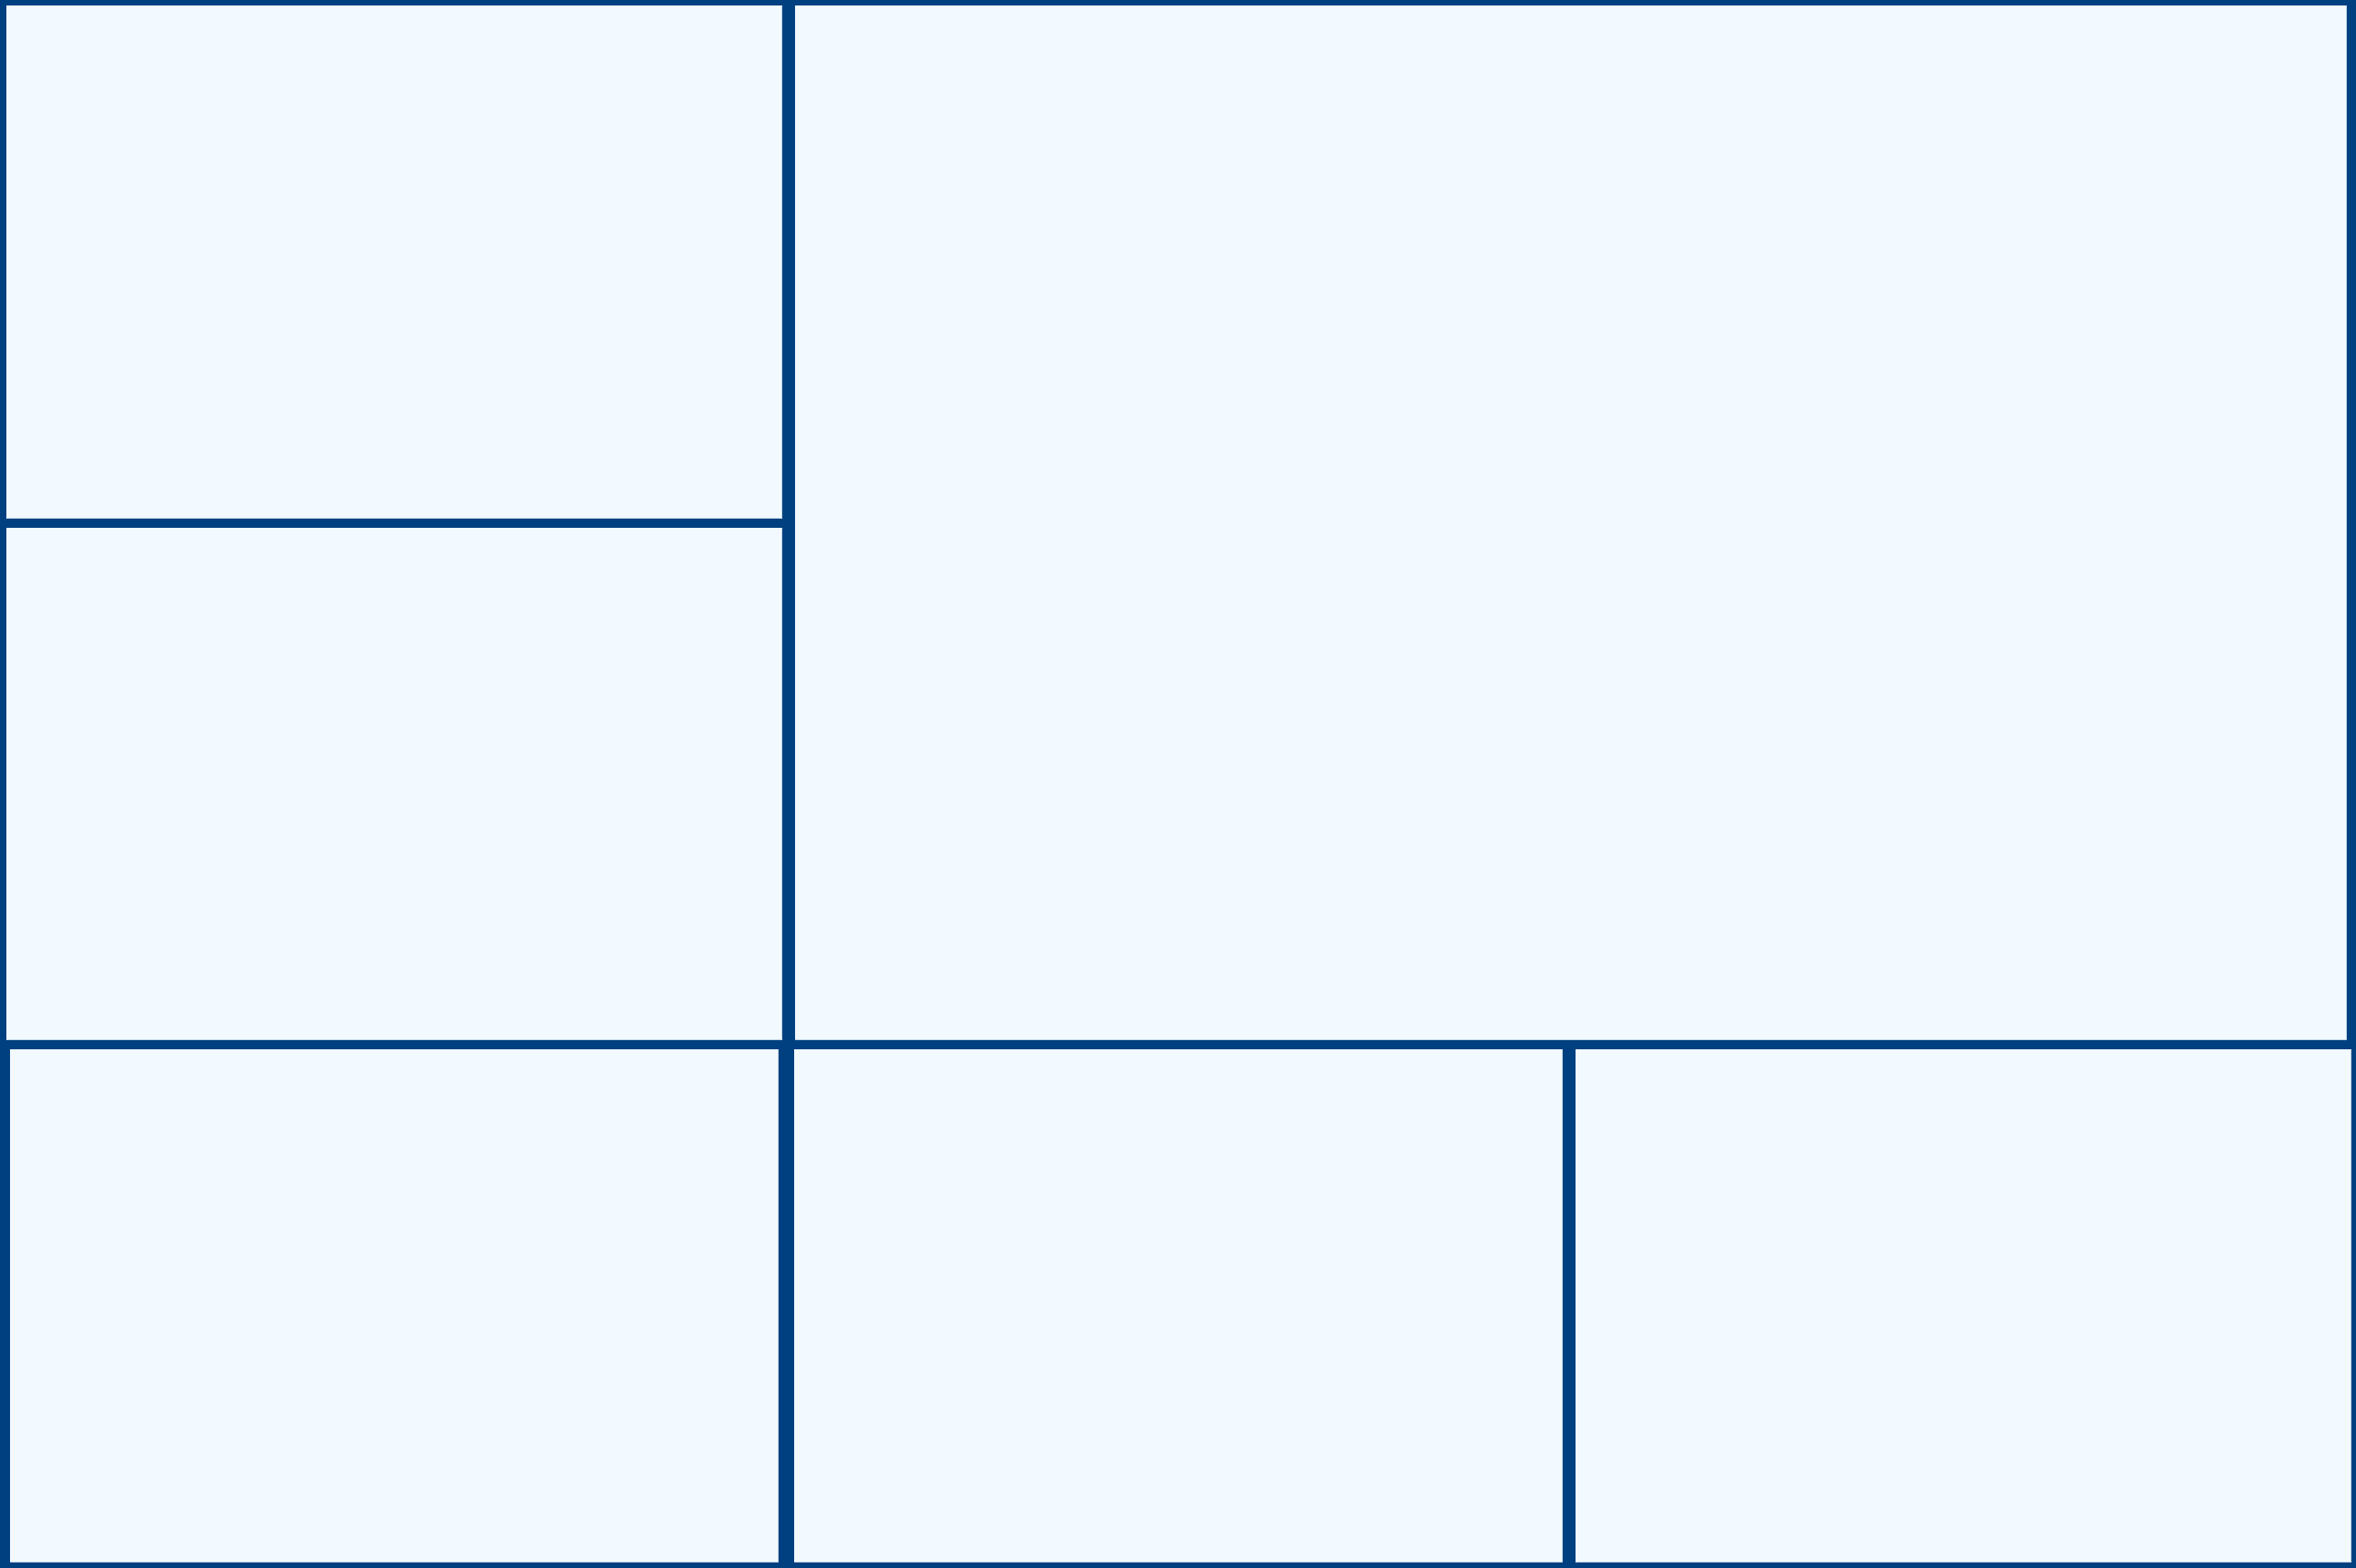

In [9]:
## computations
def process_layout():
    
    ## generate segmented plotting space
    dashboard_figure = plt.figure(figsize = (36, 24), tight_layout = True)
    fig_grid  = GridSpec(3, 3, figure = dashboard_figure)
    dashboard_figure.set_facecolor(set_color['Dividers'])
    
    ## define non-map plot panels
    axis_explanation = dashboard_figure.add_subplot(fig_grid[0, 0])
    axis_progress    = dashboard_figure.add_subplot(fig_grid[1, 0])
    axis_legend_plus = dashboard_figure.add_subplot(fig_grid[2, 2])
    
    ## define map plot panels
    axis_travels = dashboard_figure.add_subplot(fig_grid[0:2, 1:3],
        projection = map_projection)
    axis_routes = dashboard_figure.add_subplot(fig_grid[2, 1],
        projection = map_projection)
    axis_opportunity = dashboard_figure.add_subplot(fig_grid[2, 0],
        projection = map_projection)
    
    axis_travels.set_extent(map_extent)
    axis_routes.set_extent(map_extent)
    axis_opportunity.set_extent(map_extent)
    
    ## package results
    dashboard = {'travels': axis_travels,
                 'explanation': axis_explanation,
                 'routes': axis_routes,
                 'progress': axis_progress,
                 'opportunity': axis_opportunity,
                 'legend_plus': axis_legend_plus}

    for i in dashboard.keys():
        dashboard[i].tick_params(
            labelbottom = False,
            labeltop = False,
            labelleft = False,
            labelright = False,
            bottom = False,
            top = False,
            left = False,
            right = False,
            color = set_color['Coast']
            )
        for spine in dashboard[i].spines.values():
            spine.set_edgecolor(set_color['Background'])
        dashboard[i].set_facecolor( set_color['Background'] )
    
    ## return results
    return dashboard_figure, dashboard

dashboard_figure, dashboard = process_layout()

## display
def display_layout():
    dashboard_figure.savefig("C_Output/us_travels.png")
    dashboard_figure.savefig("C_Output/us_travels.pdf")
    
## execute - executed at the end of the script

## test - testing waived; individual features testing + generic testing
    ## questions will cover the same ground

# Non-Map Dashboard Panels

### Explanation: Make explanation / introduction text panel

In [10]:
## computations
def process_explanation():
    f1 = city_list.shape[0]
    f = lambda a:round(a.length * 60)
    f0 = travels.values()
    f0 = sum(map(f, f0))
    f0 = str(int(f0 / 1000)) + ',000'
    panel_paragraph['explanation'] = panel_paragraph['explanation'].format(f0,f1)
    
## display
def display_explanation():
    dashboard['explanation'].set_xlim(0, 12)
    dashboard['explanation'].set_ylim(0,  8)

    ## title
    dashboard['explanation'].text(11.9, 7.9, 
        s = 'My Travels in the US and Canada',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top'
        )
    
    ## supporting text
    dashboard['explanation'].text(0.15, 0.15,
        s = panel_paragraph['explanation'],
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'bottom'
        )
    
## execute
process_explanation()
display_explanation()

## note: testing waived; general supporting text testing does what is needed

### Progress: Make horizontal bar charts depicting progress towards city and state travel goals

In [11]:
## computations
def process_progress():
    
    ## identify unvisited cities
    city_list['Unvisit'] = 1 - city_list['Visit']
    
    ## tabulate summary statistics (state_level)
    state_stats = city_list[['State', 'Photo', 'Visit', 'Unvisit']]
    state_stats = state_stats.groupby('State').max().drop(['CAN', 'PR', 'DC'])
    state_stats['Visit'] = state_stats['Visit'] - state_stats['Photo']
    state_stats['Unvisit'] = 1 - (state_stats['Visit'] + state_stats['Photo'])
    state_stats = state_stats.sum()

    ## tabulate summary statistics (city-level)
    city_list['Visit'] = city_list['Visit'] - city_list['Photo']
    city_stats = city_list[['Photo', 'Visit', 'Unvisit']].sum()
    
    ## package and return data
    y = pd.DataFrame({
        'City': city_stats,
        'State': state_stats
    })
    y = pd.melt(y, ignore_index = False).reset_index()
    y.columns = ['Status', 'Entity', 'Count']
    return y

## display
def display_progress(x):
    
    ## set useful measurements
    use_measure = {'bar_start': 1.1, 'bar_height': 3 / 5}
    
    ## scale counts to match plotting coordinates
    func = lambda a: np.cumsum(a / sum(a))
    scaled_count = x[['Entity', 'Count']].groupby('Entity')
    scaled_count = scaled_count.transform(func)
    x['X'] = (scaled_count * (4.4 - use_measure['bar_start']))
    del scaled_count, func
    
    ## generate y coordinates
    x['Y'] = (x['Entity'] == 'State').astype(int)
    
    ## set up coordinate system
    xy_max = (4.5, 2.9, 0.1 * (3/8))
    dashboard['progress'].set_xlim(0, xy_max[0])
    dashboard['progress'].set_ylim( xy_max[1] - 3, xy_max[1])
    
    ## render horizontal barplots
    for i in ['Unvisit', 'Visit', 'Photo']:
        dashboard['progress'].barh(
            y = x.loc[x['Status'] == i, 'Entity'],
            width = x.loc[x['Status'] == i, 'X'], 
            height = use_measure['bar_height'],
            left = use_measure['bar_start'],
            align = 'edge',
            color = set_color[i],
            edgecolor = set_color['Photo'],
            linewidth = 2
            )

    ## render bar count labels
    for i in range(x.shape[0]):
        if x['Count'].astype(int)[i] > 3:
            dashboard['progress'].text(
                x = x['X'][i] - xy_max[2] + use_measure['bar_start'],
                y = x['Y'][i] + 0.02,
                s = x['Count'].astype(int)[i],
                color = set_color['Foreground'],
                fontsize = set_font['S'],
                horizontalalignment = 'right',
                verticalalignment = 'bottom',
                bbox = set_bbox
                )

    ## render legend
    dashboard['progress'].legend(
        labels = ['Unvisited', 'Visited', 'Photographed'],
        fontsize = set_font['S'],
        loc = 'upper left',
        facecolor = set_bbox['fc'],
        edgecolor = set_bbox['ec']
        )
    dashboard['progress'].text(
        x = use_measure['bar_start'] - xy_max[2],
        y = 1.0 + use_measure['bar_height'] / 2,
        s = "States",
        verticalalignment = 'center',
        horizontalalignment = 'right',
        fontsize = set_font['M']
        )
    dashboard['progress'].text(
        x = use_measure['bar_start'] - xy_max[2],
        y = 0.0 + use_measure['bar_height'] / 2,
        s = "Metropolitan\nAreas",
        verticalalignment = 'center',
        horizontalalignment = 'right',
        fontsize = set_font['M']
        )
    
    ## render title and explanation
    dashboard['progress'].text(
        xy_max[0] - xy_max[2], xy_max[1] - xy_max[2], 
        s = 'Progress Toward Goal',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top'
        )
    
    ## supporting text
    dashboard['progress'].text(
        0.1 + 0.1, xy_max[1] - 0.25,
        s = '\n' + panel_paragraph['progress'],
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'top'
        )

## execute
progress = process_progress()
display_progress(x = progress.copy())

### Progress: Testing

In [12]:
def test_progress(prog = progress.copy(), cl = city_list.copy()):
    full_pass = True
    
    ## Are there 50 states and 128 cities?
    prog_count = prog[['Entity', 'Count']].groupby('Entity').sum().squeeze()
    if prog_count['City'] == 128 and prog_count['State'] == 50:
        pass
    else:
        print('WARNING (test_progress) - Incorrect number of cities and states')
        full_pass = False
    
    ## Do the city counts match the input file sums?
    cl.Unvisit = (1 - cl.Visit) * (1 - cl.Photo)
    count_match = {
        'Source' :cl[['Visit', 'Photo', 'Unvisit']].sum(),
        'Product':prog[prog.Entity == 'City'][['Status', 'Count']]
        }
    count_match['Product'] = count_match['Product'].set_index('Status').squeeze()
    count_match = pd.concat(count_match, axis = 1)
    count_match = count_match.Source - count_match.Product
    if any(count_match != 0):
        print('WARNING (test_progress) - City Photo/Visit counts do not match')
        full_pass = False
        
    ## add manual checks to manual checklist
    manual_check_list.update({
        'Progress - Are there 2 barplots, each with a label to the left?':'y',
        'Progress - Is there a legend?':'y',
        'Progress - Do the three legend colors correspond to bar regions?':'y',
        'Progress - Do bar chart region counts correspond to region length?':'y'
    })
        
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_progress')

test_progress()

### Legend Plus: Display table with legend and other information about planned routes

In [13]:
## computations
class LegendTable:
    
    def __init__(self, pd_df):
        pd_df_copy = pd_df.copy()
        x = pd_df_copy['drive_mileage'].values
        x = np.ceil(x / 25) * 25
        pd_df_copy.loc[:, 'drive_mileage'] = x.astype(int)
        self.table = [list(pd_df_copy.iloc[i]) for i in range(pd_df_copy.shape[0])]
        self.index = pd_df_copy.index
        self.columns = pd_df_copy.columns
        del pd_df_copy, x
        
    def __str__(self):
        print('Columns:')
        for i in self.columns:
            print(i, end = ' ')
        print('\n----')
        for i in self.table:
            print(i)
        return ''


def process_legend_plus(rl = route_list):
    rl = rl[['route', 'pre_travel', 'drive_mileage', 'trip_days',
             'best_temp_1', 'best_temp_2', 'Score', 'states_etc']]
    return LegendTable(rl)
    
## display
def display_legend_plus(rl):
    
    ## set parameters for plot
    dashboard['legend_plus'].set_xlim(0, 12)
    dashboard['legend_plus'].set_ylim(0, 8)
    
    ## set display column names
    col_display_names = {'route': 'Route', 'pre_travel':'Pre-Travel',
                         'drive_mileage':'Miles', 'trip_days':'Days',
                         'best_temp_1':'Temperate In', 'best_temp_2':'',
                         'Score':'Value', 'states_etc':'States And Equiv.'
                        }
    
    ## determine max width for each column
    str_len = lambda a: len(str(a))
    col_width = []
    for i in rl.table:
        col_width.append(list(map(str_len, i)))
    col_width = np.array(col_width).max(axis = 0).astype(float)
    for i in range(len(col_width)):
        col_width[i] = max(col_width[i], len(rl.columns[i]))
    col_width /= col_width.sum()
    
    ## render table
    y = dashboard['legend_plus'].table(
        cellText = rl.table,
        rowLabels = None,
        colLabels = [col_display_names[i] for i in rl.columns],
        edges = 'open',
        loc = 'lower right',
        colLoc = 'left',
        cellLoc = 'left',
        colWidths = col_width,
        bbox = [0.01, 0.01, 0.99, 0.9]
        )
    y.auto_set_font_size(False)
    y.set_fontsize(set_font['S'] - 1)
    y.scale(1, 2.6)

    ## title
    dashboard['legend_plus'].text(11.9, 7.9, 
        s = 'Planned Routes Information',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top'
        )

## execute
legend_plus = process_legend_plus()
display_legend_plus(legend_plus)

### Test Legend Plus Panel

In [14]:
## test legend plus panel
def test_legend_plus(lp = legend_plus, rl = route_list.copy()):
    full_pass = True
    
    ## Does every table entry correspond to the route table?
    same_table = True
    for i in range(len(lp.table)):
        if lp.table[i] != list(rl.loc[i]):
            print('WARNING (test_legend_plus) - Route list entries' +
              ' do not match legend plus table entries')
            full_pass = False
            break
    
    ## add manual checks to manual checklist
    manual_check_list.update({
        'Legend Plus - Are {0} unique columns visible in the data table?'.format(rl.shape[1]):'y',
        'Legend Plus - Are {0} unique rows visible in the data table?'.format(rl.shape[0]):'y'
    })
    
    ## add to warning summary if needed
    if not full_pass:
        test_failures.append('test_legend_plus')
        
test_legend_plus()

# Map Dashboard Panels

### Map: Make the background map underlying the map panels

In [15]:
## computations (not needed so far; keeping stub here just in case)
def process_map():
    pass

## display
def display_map():
    
    ## add coastlines and state borders to plot
    for i in ['travels', 'routes']:
        dashboard[i].add_feature(ct.feature.LAND,
                                 lw = 1,
                                 edgecolor = (0, 0, 0, 0),
                                 facecolor = set_color['Land']
                                )
        dashboard[i].add_feature(ct.feature.STATES,
                                    lw = 1,
                                    edgecolor = set_color['Border']
                                   )
        dashboard[i].add_feature(ct.feature.COASTLINE,
                                    lw = 1,
                                    edgecolor = set_color['Coast']
                                   )
        dashboard[i].add_feature(ct.feature.LAKES,
                                    lw = 1,
                                    edgecolor = set_color['Border'],
                                    facecolor = set_color['Background']
                                   )
    
## test
def test_map():
    pass

## execute
display_map()

## test - testing waived; individual features testing + generic testing
    ## questions will cover the same ground

### Routes: Map planned routes

In [16]:
## computations (just a stub for now
def process_routes(rt = routes):
    return rt

## display
def display_routes(rt):
    
    ## render planned routes
    for i in rt.keys():
        dashboard['routes'].add_geometries(
            rt[i],
            crs = ct.crs.PlateCarree(),
            edgecolor = set_color['Photo'],
            facecolor = (0,0,0,0),
            linewidth = 2
            )
    
    ## render metro areas
    dashboard['routes'].scatter(
        city_list.lon.values,
        city_list.lat.values,
        facecolors = set_color['Photo'],
        edgecolors = set_color['Background'],
        transform = ct.crs.PlateCarree(),
        linewidths = 2,
        s = 2 * plt.rcParams['lines.markersize'] * 2**2
        )
        
    ## render title
    dashboard['routes'].text(-62, 49.8, 
        s = 'Map of Planned Routes',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top',
        transform = ct.crs.PlateCarree(),
        bbox = set_bbox
        )
    
    ## render supporting text
    dashboard['routes'].text(-119, 22 + 0.5,
        s = panel_paragraph['routes'],
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'bottom',
        transform = ct.crs.PlateCarree(),
        zorder = 99,
        bbox = set_bbox
        )
    
    
routes = process_routes()
display_routes(routes)

### Routes: Testing

In [17]:
## test
def test_routes(r = routes, rl = route_list):
    q1 = 'Routes - Are {0} routes shown on the map?'.format(len(r))
    q2 = sum(rl['pre_travel'] == 'None')
    q2 = 'Routes - Do exactly {0} routes overlap?'.format(q2)
    manual_check_list.update({
        q1:'y',
        q2:'y',
        'Routes - Do the routes pass through every US State?':'y'
    })
 
test_routes()

### Travels: Map past travels

In [18]:
## computations
def process_travels(x = travels):
    
    ## plug missing statistics into supporting text.
    state_index = progress.Entity == 'State'
    visited_index = progress.Status != 'Unvisit'
    progress_percent = progress['Count'][~state_index & visited_index].sum()
    progress_percent = progress_percent / progress['Count'][~state_index].sum()
    progress_percent = int(progress_percent * 100)
    
    panel_paragraph['travels'] = panel_paragraph['travels'].format(
        progress['Count'][state_index & visited_index].sum(),
        progress['Count'][~state_index & visited_index].sum(),
        progress_percent
        )
    
    ## use the same LineString processing function as used in the routes map
    return process_routes(x)

## display travel panel
def display_travels(rt):
    
    ## render past travel routes
    for i in rt.keys():
        dashboard['travels'].add_geometries(
            rt[i],
            crs = ct.crs.PlateCarree(),
            edgecolor = set_color['Photo'],
            facecolor = (0,0,0,0),
            linewidth = 2
        )
        
    ## color-code metro areas
    metro_color = city_list.copy()[['lon', 'lat']]
    metro_color.loc[:, 'category'] = 'Unvisit'
    metro_color.loc[:, 'color'] = 'Unvisit'
    metro_color.loc[city_list.Visit.astype(bool), 'category'] = 'Visit'
    metro_color.loc[city_list.Photo.astype(bool), 'category'] = 'Photo'
    for i in set(metro_color.category):
        metro_color.loc[metro_color.category == i, 'color'] = set_color[i]
        
    ## render metro areas
    dashboard['travels'].scatter(
        metro_color.lon.values,
        metro_color.lat.values,
        facecolors = metro_color.color.values,
        edgecolors = set_color['Photo'],
        transform = ct.crs.PlateCarree(),
        linewidths = 2,
        s = 2 * plt.rcParams['lines.markersize'] * 2**4
        )
        
    ## render title
    dashboard['travels'].text(-62, 50, 
        s = 'My Travels So Far',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top',
        transform = ct.crs.PlateCarree(),
        bbox = set_bbox
        )
    
    ## render supporting text
    dashboard['travels'].text(-119.4, 22.1,
        s = panel_paragraph['travels'],
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'bottom',
        transform = ct.crs.PlateCarree(),
        bbox = set_bbox
        )

travels = process_travels()
display_travels(travels)

### Travels - Testing

In [19]:
## test
def test_travels():
    q1 = (progress['Entity'] == 'State') & (progress['Status'] != 'Unvisit')
    q1 = progress[q1]['Count'].sum()
    manual_check_list.update({
        'Travels - Do the routes pass through {0} US States?'.format(q1):'y',
        'Travels - Are the cities dotted and color coded?':'y'
    })
 
test_travels()

### Opportunity: Map geographic areas where visit will contribute to goals
+ Kernel density heat map with plasma color scaling

In [20]:
set_op_color = [
    set_color['Land'],
    hsv(6/12, 0.1, 0.9),
    hsv(6/12, 0.2, 0.7),
    hsv(6/12, 0.3, 0.5),
    hsv(6/12, 0.4, 0.3)
  ]

## define function to calculate distances
def calculate_distance(x1, x2):
    ## make an empty matrix to hold results
    x1n = x1.shape[0]
    x2n = x2.shape[0]
    dist = np.zeros((x1n, x2n)).astype(int)
        
    ## calculate distance for each point
    for i in range(x1n):
        for j in range(x2n):
            dist[i, j] = int(earth_distance(
                tuple(x1[['lat', 'lon']].iloc[i]),
                tuple(x2[['lat', 'lon']].iloc[j])
                ).mi)
            dist[i, j] = int(dist[i, j])
    return dist

## define processing function
def process_opportunity(cl = city_list):
    
    ## remove PR, HI, AK from data
    cl = cl[~cl.State.isin(['AK', 'HI', 'PR'])]
    
    ## trim excess precision
    cl = cl.round(2)
    
    ## generate a meshgrid
    us_mesh = np.meshgrid(
        np.arange(cl['lon'].min()-1, cl['lon'].max()+1, 1.0),
        np.arange(cl['lat'].min()-1, cl['lat'].max()+1, 1.0)
        )
    for i in range(2):
        us_mesh[i] = us_mesh[i].reshape(us_mesh[i].size)
    us_mesh = pd.DataFrame(us_mesh).T
    us_mesh.columns = ['lon', 'lat']
    
    ## generate row indices for the mesh grid
    us_mesh['lon_ind'] = pd.Categorical(us_mesh.lon).codes
    us_mesh['lat_ind'] = pd.Categorical(us_mesh.lat).codes
    us_mesh = us_mesh.set_index(['lon_ind', 'lat_ind'])
    
    ## calculate proximity for each mesh point (retrieve from disk if possible)
    try:
        dist = np.load('B_Process/dist.npy')
    except:
        dist = np.zeros((1,))

    if dist.shape == (cl.shape[0], us_mesh.shape[0]):
        pass
    else:
        dist = calculate_distance(cl, us_mesh)
        np.save('B_Process/dist.npy', dist)

    ## convert distance to proximity
    dist = dist < set_misc['prox_threshold']
    dist = dist.astype(int)
    
    ## calculate opportunity score for each point; package for return
    us_mesh['Score'] = np.matmul(dist.T, cl.Score.values)
    us_mesh = us_mesh.reset_index()
    new_shape = (max(us_mesh.lat_ind) + 1, max(us_mesh.lon_ind) + 1)
    us_mesh = [
        us_mesh.lon.values.reshape(new_shape),
        us_mesh.lat.values.reshape(new_shape),
        us_mesh.Score.values.reshape(new_shape)
    ]
    return us_mesh
    
## display
def display_opportunity(op, txt = panel_paragraph['opportunity']):

    ## determine color breaks
    color_breaks = np.zeros(6,)
    color_breaks[0:4] = (0, 0.9, 1.9, 2.9)
    color_breaks[5]   = op[2].max() + 0.1
    color_breaks[4]   = (color_breaks[5] + color_breaks[3]) / 2
    color_breaks = np.unique(color_breaks)

    ## generate contours
    dashboard['opportunity'].contourf(
        np.unique(op[0]),
        np.unique(op[1]),
        op[2],
        levels = color_breaks,
        colors = set_op_color,
        transform = ct.crs.PlateCarree()
        )


    ## mask contours for non-land
    dashboard['opportunity'].add_feature(ct.feature.LAND,
                                    lw = 1,
                                    color = set_color['Land']
                                   )
    dashboard['opportunity'].add_feature(ct.feature.OCEAN,
                                    lw = 1,
                                    facecolor = set_color['Background'],
                                    edgecolor = set_color['Coast'],
                                    zorder = 98
                                   )
    dashboard['opportunity'].add_feature(ct.feature.LAKES,
                                    lw = 1,
                                    facecolor = set_color['Background'],
                                    edgecolor = set_color['Border']
                                   )
    dashboard['opportunity'].add_feature(ct.feature.STATES,
                                    lw = 1,
                                    edgecolor = set_color['Border']
                                   )

    # title
    dashboard['opportunity'].text(-62, 49.8, 
        s = 'Opportunities For Goal Progress',
        fontsize = set_font['L'],
        color = set_color['Foreground'],
        horizontalalignment = 'right',
        verticalalignment = 'top',
        transform = ct.crs.PlateCarree(),
        zorder = 99,
        bbox = set_bbox
        )
    
    ## supporting text
    dashboard['opportunity'].text(-119, 22 + 0.5,
        s = panel_paragraph['opportunity'],
        fontsize = set_font['M'],
        color = set_color['Foreground'],
        horizontalalignment = 'left',
        verticalalignment = 'bottom',
        transform = ct.crs.PlateCarree(),
        zorder = 99,
        bbox = set_bbox
        )

## execute
opportunity = process_opportunity()
display_opportunity(opportunity)

### Opportunity - Testing

In [21]:
## test
def test_opportunity(cl = city_list.copy()):
    ## prune data
    cl = cl[['City', 'lon', 'lat', 'Score']].set_index('City')
    cl_score = cl['Score']
    cl = cl.drop('Score', axis = 1)
    
    ## calculate distance between points
    try:
        metro_dist = np.load('B_Process/metro_dist.npy')
        assert metro_dist.shape[0] == cl.shape[0]
    except:
        print('Recalculating distance...')
        metro_dist = calculate_distance(cl, cl)
        np.save('B_Process/metro_dist.npy', metro_dist)

    cl_prox_score = metro_dist <= set_misc['prox_threshold']
    del metro_dist
    
    ## calculate score for each point
    cl_prox_score =  np.matmul(np.array(cl_score), cl_prox_score)
    cl_prox_score = pd.Series(cl_prox_score, index = cl.index)
    del cl, cl_score
    cl_prox_score.sort_values(inplace = True, ascending = False)
    
    ## find cities with the high and low scores
    top_list = cl_prox_score[cl_prox_score > (cl_prox_score.max() * 0.9)]
    low_list = cl_prox_score[cl_prox_score == 0]
    
    ## update the manual testing checklist accordingly
    if len(top_list) > 0:
        if len(top_list) > 5: top_list = top_list[0:5]
        top_list = '\n' + '\n'.join(list(top_list.index))
        q1 = 'Opportunity - is there heavy shading surround these cities? {0}'
        q1 = q1.format(top_list)
        manual_check_list.update({q1:'y'})
    
    if len(low_list) > 0:
        if len(low_list) > 5: low_list = low_list[0:5]
        low_list = '\n' + '\n'.join(list(low_list.index))
        q2 = 'Opportunity - is there minimal shading surround these cities? {0}'
        q2 = q2.format(low_list)
        manual_check_list.update({q2:'y'})

## conduct quality testing
test_opportunity()

# Finalization Tasks

### Finish Rendering Visualization

In [22]:
display_layout()

### final testing

In [23]:
## Report problems found during automated testing
print('== Automated quality testing: ========')
if len(test_failures) > 0:
    print('\nThese automated tests found potential problems:')
    for i in test_failures:
        print("  " + i)
else: print('Automated quality testing found no issues')
        
## Conduct manual testing
def manual_testing(proceed = True):
    print('\n== Manual quality check list: ========')
    clean_run = True
    if proceed:
        for i in manual_check_list.keys():
            manual_check_list[i] = input(i)
        if clean_run:
            print("Manual quality testing found no issues")
        else:
            print('\nThese manual checks found potential problems:')
        for i in manual_check_list.keys():
            if manual_check_list[i] == 'n':
                clean_run = False
                print('  ' + i)
    else:
        print('\nWARNING (manual_testing) - Manual testing is currently switched off')

manual_testing(set_misc['manual_test'])
time_check('Z')

== Automated quality testing: ========

These automated tests found potential problems:
  test_texts

== Manual quality check list: ========

WARNING (manual_testing) - Manual testing is currently switched off
Time Check: Point Z
2022-03-26 10:27:23.324148
